In [1]:
sc

<SparkContext master=local[*] appName=Jupyter Notebook #2>

In [2]:
spark

In [3]:
import pyspark.sql.functions as f
import pandas as pd
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.mllib.classification import SVMWithSGD
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
import nltk
from nltk.tokenize import word_tokenize

In [4]:
#df = spark.read.json('s3://trendsyelp/review.json')

#df = spark.read.option('inferSchema','true').format('json').load('s3://trendsyelp/review.json')

df = spark.read.option('inferSchema','true').format('json').load('review.json')

In [ ]:
# target list business id

idlist = ['4JNXUYY8wbaaDmk3BPzlWw'
,'RESDUcs7fIiihp38-d6_6g'
,'K7lWdNUhCbcnEvI0NhGewg'
,'f4x1YBxkLrZg652xt2KR5g'
,'cYwJA2A6I12KNkm2rtXd5g'
,'DkYS3arLOhA8si5uUEmHOw'
,'2weQS-RnoOBhb1KsHKyoSQ'
,'5LNZ67Yw9RD6nf4_UhXOjw'
,'iCQpiavjjPzJ5_3gPD5Ebg'
,'ujHiaprwCQ5ewziu0Vi9rw'
,'SMPbvZLSMMb7KU76YNYMGg'
,'AV6weBrZFFBfRGCbcRGO4g'
,'KskYqH1Bi7Z_61pH6Om8pg'
,'El4FC8jcawUVgw_0EIcbaQ'
,'eoHdUeQDNgQ6WYEnP2aiRw'
,'rcaPajgKOJC2vo_l3xa42A'
,'FaHADZARwnY4yvlvpnsfGA'
,'faPVqws-x-5k2CQKDNtHxw'
,'OETh78qcgDltvHULowwhJg'
,'Wxxvi3LZbHNIDwJ-ZimtnA']

In [ ]:
# train model with data exclude targeted business id

df = df.where(~df['business_id'].isin(idlist))

In [5]:
# show schema

df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [6]:
df.cache()


DataFrame[business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: double, text: string, useful: bigint, user_id: string]

In [7]:
# remove punctuations and 

import string
import re

def remove_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)  
    return nopunct

def convert_rating(rating):
    if rating >=4:
        return 1
    else:
        return 0

In [149]:
from pyspark.sql.functions import udf

punct_remover = udf(lambda x: remove_punct(x))
rating_convert = udf(lambda x: convert_rating(x))

 = 
df_text = df.select('business_id', 'date', punct_remover('text'), rating_convert('stars'))



df_text = df_text.withColumnRenamed('<lambda>(text)', 'text')
df_text = df_text.withColumnRenamed('<lambda>(stars)', 'rate')

In [150]:
df_text.show()

+--------------------+-------------------+--------------------+----+
|         business_id|               date|                text|rate|
+--------------------+-------------------+--------------------+----+
|ujmEBvifdJM6h6RLv...|2013-05-07 04:34:36|Total bill for th...|   0|
|NZnhc2sEQy3RmzKTZ...|2017-01-14 21:30:33|I  adore  Travis ...|   1|
|WTqjgwHlXbSFevF32...|2016-11-09 20:09:03|I have to say tha...|   1|
|ikCg8xy5JIg_NGPx-...|2018-01-09 20:56:38|Went in for a lun...|   1|
|b1b1eb3uo-w561D0Z...|2018-01-30 23:07:38|Today was my seco...|   0|
|eU_713ec6fTGNO4Be...|2013-01-20 13:25:59|I ll be the first...|   1|
|3fw2X5bZYeW9xCz_z...|2016-05-07 01:21:02|Tracy dessert had...|   0|
|zvO-PJCpNk4fgAVUn...|2010-10-05 19:12:35|This place has go...|   0|
|b2jN2mm9Wf3RcrZCg...|2015-01-18 14:04:18|I was really look...|   0|
|oxwGyA17NL6c5t1Et...|2012-02-29 21:52:43|It s a giant Best...|   0|
|8mIrX_LrOnAqWsB5J...|2011-11-30 02:11:15|Like walking back...|   1|
|mRUVMJkUGxrByzMQ2...|2017-12-15 2

In [151]:
df_text.cache()

DataFrame[business_id: string, date: string, text: string, rate: string]

In [152]:
# tolenize the text

from pyspark.ml.feature import *
from pyspark.ml import Pipeline
#tokenizer and stop word remover
tok = Tokenizer(inputCol="text", outputCol="words")
#stop word remover
stopwordrm = StopWordsRemover(inputCol='words', outputCol='words_new')
# Build the pipeline 
pipeline = Pipeline(stages=[tok, stopwordrm])
# Fit the pipeline 
review_tokenized = pipeline.fit(df_text).transform(df_text).cache()

In [12]:
review_tokenized.show()

+--------------------+-------------------+--------------------+----+--------------------+--------------------+
|         business_id|               date|                text|rate|               words|           words_new|
+--------------------+-------------------+--------------------+----+--------------------+--------------------+
|ujmEBvifdJM6h6RLv...|2013-05-07 04:34:36|Total bill for th...|   0|[total, bill, for...|[total, bill, hor...|
|NZnhc2sEQy3RmzKTZ...|2017-01-14 21:30:33|I  adore  Travis ...|   1|[i, , adore, , tr...|[, adore, , travi...|
|WTqjgwHlXbSFevF32...|2016-11-09 20:09:03|I have to say tha...|   1|[i, have, to, say...|[say, office, rea...|
|ikCg8xy5JIg_NGPx-...|2018-01-09 20:56:38|Went in for a lun...|   1|[went, in, for, a...|[went, lunch, , s...|
|b1b1eb3uo-w561D0Z...|2018-01-30 23:07:38|Today was my seco...|   0|[today, was, my, ...|[today, second, t...|
|eU_713ec6fTGNO4Be...|2013-01-20 13:25:59|I ll be the first...|   1|[i, ll, be, the, ...|[ll, first, admit...|
|

In [153]:
# n gram

ngram = NGram(inputCol = 'words_new', outputCol = 'ngram', n = 3)
add_ngram = ngram.transform(review_tokenized)

In [154]:
# count vectorizer

cv_ngram = CountVectorizer(inputCol='ngram', outputCol='tf_ngram')
cvModel_ngram = cv_ngram.fit(add_ngram)
cv_df_ngram = cvModel_ngram.transform(add_ngram)

In [155]:
# create TF-IDF matrix

idf_ngram = IDF().setInputCol('tf_ngram').setOutputCol('tfidf_ngram')
tfidfModel_ngram = idf_ngram.fit(cv_df_ngram)
tfidf_df_ngram = tfidfModel_ngram.transform(cv_df_ngram)

In [156]:
# train test split

splits_ngram = tfidf_df_ngram.select(['tfidf_ngram', 'rate']).randomSplit([0.8,0.2],seed=100)
train_ngram = splits_ngram[0].cache()
test_ngram = splits_ngram[1].cache()

In [157]:
splits_ngram[1].show()

+--------------------+----+
|         tfidf_ngram|rate|
+--------------------+----+
|(262144,[0,1,2,3,...|   1|
|(262144,[0,1,2,3,...|   1|
|(262144,[0,1,2,4,...|   0|
|(262144,[0,1,2,4,...|   0|
|(262144,[0,1,2,5,...|   0|
|(262144,[0,1,2,6,...|   0|
|(262144,[0,1,2,7,...|   1|
|(262144,[0,1,2,7,...|   0|
|(262144,[0,1,2,7,...|   0|
|(262144,[0,1,2,12...|   0|
|(262144,[0,1,2,12...|   0|
|(262144,[0,1,2,35...|   0|
|(262144,[0,1,3,4,...|   0|
|(262144,[0,1,3,5,...|   0|
|(262144,[0,1,3,8,...|   0|
|(262144,[0,1,3,13...|   1|
|(262144,[0,1,4,5,...|   0|
|(262144,[0,1,4,5,...|   1|
|(262144,[0,1,4,15...|   0|
|(262144,[0,1,4,24...|   1|
+--------------------+----+
only showing top 20 rows



In [158]:
# Convert feature matrix to vectors

train_lb_ngram = train_ngram.rdd.map(lambda row: LabeledPoint(row[1], Vectors.fromML(row[0])))
test_lb_ngram = test_ngram.rdd.map(lambda row: LabeledPoint(row[1], Vectors.fromML(row[0])))

In [159]:
# svm model

numIterations = 50
regParam = 0.3
svm = SVMWithSGD.train(train_lb_ngram, numIterations, regParam=regParam)

#test_lb = test.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))
scoreAndLabels_test = test_lb_ngram.map(lambda x: (float(svm.predict(x.features)), x.label))
score_label_test = spark.createDataFrame(scoreAndLabels_test, ["prediction_rate", "actual_rate"])

In [160]:
scoreAndLabels_test.take(3)

[(1.0, 1.0), (1.0, 1.0), (0.0, 0.0)]

In [161]:
score_label_test.show()

+---------------+-----------+
|prediction_rate|actual_rate|
+---------------+-----------+
|            1.0|        1.0|
|            1.0|        1.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        1.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        0.0|
|            0.0|        1.0|
|            0.0|        0.0|
|            1.0|        1.0|
|            0.0|        0.0|
|            0.0|        1.0|
+---------------+-----------+
only showing top 20 rows



In [162]:
# f1 score

f1_eval = MulticlassClassificationEvaluator(labelCol="actual_rate", predictionCol="prediction_rate", metricName="f1")
svm_f1 = f1_eval.evaluate(score_label_test)
print("F1 score: %.4f" % svm_f1)

F1 score: 0.8112


## target id

In [163]:
# top 20 id

idlist = ['4JNXUYY8wbaaDmk3BPzlWw'
,'RESDUcs7fIiihp38-d6_6g'
,'K7lWdNUhCbcnEvI0NhGewg'
,'f4x1YBxkLrZg652xt2KR5g'
,'cYwJA2A6I12KNkm2rtXd5g'
,'DkYS3arLOhA8si5uUEmHOw'
,'2weQS-RnoOBhb1KsHKyoSQ'
,'5LNZ67Yw9RD6nf4_UhXOjw'
,'iCQpiavjjPzJ5_3gPD5Ebg'
,'ujHiaprwCQ5ewziu0Vi9rw'
,'SMPbvZLSMMb7KU76YNYMGg'
,'AV6weBrZFFBfRGCbcRGO4g'
,'KskYqH1Bi7Z_61pH6Om8pg'
,'El4FC8jcawUVgw_0EIcbaQ'
,'eoHdUeQDNgQ6WYEnP2aiRw'
,'rcaPajgKOJC2vo_l3xa42A'
,'FaHADZARwnY4yvlvpnsfGA'
,'faPVqws-x-5k2CQKDNtHxw'
,'OETh78qcgDltvHULowwhJg'
,'Wxxvi3LZbHNIDwJ-ZimtnA']

In [164]:
df_id = df.where(df.business_id.isin(idlist))

In [187]:
df_id.business_id

Column<b'business_id'>

In [165]:
df_id.cache()

DataFrame[business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: double, text: string, useful: bigint, user_id: string]

In [166]:
df_id.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [167]:

df_id_text = df_id.select('business_id', 'date', punct_remover('text'), rating_convert('stars'))
df_id_text = df_id_text.withColumnRenamed('<lambda>(text)', 'text')
df_id_text = df_id_text.withColumnRenamed('<lambda>(stars)', 'rate')
df_id_text.cache()

DataFrame[business_id: string, date: string, text: string, rate: string]

In [168]:

#tokenizer and stop word remover
tok = Tokenizer(inputCol="text", outputCol="words")
#stop word remover
stopwordrm = StopWordsRemover(inputCol='words', outputCol='words_new')
# Build the pipeline 
pipeline = Pipeline(stages=[tok, stopwordrm])
# Fit the pipeline 
review_tokenized_id = pipeline.fit(df_id_text).transform(df_id_text).cache()

In [169]:
# ngram

ngram = NGram(inputCol = 'words_new', outputCol = 'ngram', n = 3)
add_ngram_id = ngram.transform(review_tokenized_id)

In [170]:
# count vectorizer

cv_ngram = CountVectorizer(inputCol='ngram', outputCol='tf_ngram')
cvModel_ngram_id = cv_ngram.fit(add_ngram_id)
cv_df_ngram_id = cvModel_ngram_id.transform(add_ngram_id)

In [171]:
# create TF-IDF matrix

idf_ngram = IDF().setInputCol('tf_ngram').setOutputCol('tfidf_ngram')
tfidfModel_ngram_id = idf_ngram.fit(cv_df_ngram_id)
tfidf_df_ngram_id = tfidfModel_ngram_id.transform(cv_df_ngram_id)

In [172]:
final_id = tfidf_df_ngram_id.select(['tfidf_ngram', 'rate'])

In [174]:
# Convert feature matrix to vectors

final_id = final_id.rdd.map(lambda row: LabeledPoint(row[1], Vectors.fromML(row[0])))

In [175]:
final_id

PythonRDD[746] at RDD at PythonRDD.scala:53

In [176]:
final_id.take(3)

[LabeledPoint(0.0, (262144,[686,988,1396,1664,2509,2511,2937,3659,5317,5568,9434,15764,18094,19733,25411,30501,31000,31510,33340,47437,49228,51639,56542,74302,77715,89122,103894,104847,112940,136920,137874,145648,158629,166802,169431,182214,183526],[5.2197527719760455,5.4967797765277755,5.783630939085469,5.9455637593547825,6.28673451675755,6.30335539799359,6.421837001614113,6.623206753378763,6.99093153350408,7.024833085179761,7.483408018601874,7.907222265378235,8.025005301034618,8.12344537384787,8.3126873734864,8.495008930280354,8.495008930280354,8.495008930280354,8.546302224667905,8.851683874219086,8.851683874219086,8.925791846372809,9.005834554046345,9.1881561108403,9.293516626498125,9.293516626498125,9.411299662154509,9.411299662154509,9.544831054779031,9.69898173460629,9.69898173460629,9.69898173460629,9.69898173460629,9.881303291400245,9.881303291400245,9.881303291400245,9.881303291400245])),
 LabeledPoint(1.0, (262144,[2425,97496,119957],[6.259632586979758,9.411299662154509,9.544

In [177]:
final_id_test = final_id.map(lambda x:(float(svm.predict(x.features)), float(x.label)))

In [178]:
final_id_test.take(1)

[(0.0, 0.0)]

In [179]:
# predict

final_id_test = final_id.map(lambda x: (float(svm.predict(x.features)), x.label))
final_test = spark.createDataFrame(final_id_test, ["prediction_rate", "actual_rate"])

In [198]:
final_df = final_test.select('prediction_rate').toPandas()

In [219]:
business_id = df_id.toPandas()

In [220]:
business = business_id.merge(final_df,left_index=True, right_index=True)

In [224]:
business['actual_rate'] = business['stars'].apply(convert_ratingt_rating)

In [225]:
business

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,prediction_rate,actual_rate
0,ujHiaprwCQ5ewziu0Vi9rw,0,2013-12-07 00:14:06,0,f0B9-r14-bLudyu5S7aLhw,1.0,We had dinner at the Bellagio Buffet last nigh...,1,SvMGr_Oih7ivtzmnCL-Tmg,0.0,0
1,faPVqws-x-5k2CQKDNtHxw,0,2018-08-04 20:22:15,0,w1I8U4cJ4QGaXA98ImNrbA,5.0,"Service was amazing, Christina was extremely t...",0,rJNdeta-dYO2YcJ3u5JxnA,0.0,1
2,Wxxvi3LZbHNIDwJ-ZimtnA,2,2011-07-28 09:06:59,4,Sft1a3j3Hst44CG9gbww0Q,1.0,I am so blown away by this sophisticated & bea...,8,FBxhaS2bPmxwT3I8r3CmkQ,0.0,0
3,ujHiaprwCQ5ewziu0Vi9rw,0,2015-12-05 03:28:19,0,A4G1-LTupScgaPmXF1OPMg,4.0,Around $45 for a dinner on a Friday night.\nSn...,0,W2WICriV5Zf03S4ETzEsiQ,1.0,1
4,Wxxvi3LZbHNIDwJ-ZimtnA,0,2016-07-14 18:58:35,0,EaXwNVOmpCXwCchMR5TWlQ,3.0,Paid for a view of the strip...Very disappoint...,0,vRSetBkuRMrjZvpW76gXFA,1.0,0
5,Wxxvi3LZbHNIDwJ-ZimtnA,0,2018-09-03 01:24:02,0,Rm5rDYHyEwMkk-jAb2qGHg,1.0,It's extremely annoying that the Venetian choo...,0,P3hFkQQZOTCM5Q1cgOCEog,1.0,0
6,Wxxvi3LZbHNIDwJ-ZimtnA,0,2018-08-30 03:08:26,0,9XiyPxxdlJgNhkD8ghG3Uw,5.0,The nicest hotel I've ever stayed in in Vegas!...,1,IpY_dVyIFBCPkHJzBy-yeg,1.0,1
7,Wxxvi3LZbHNIDwJ-ZimtnA,0,2015-09-24 00:32:53,0,qanp3i2J7ujsDw4k7xxAHg,4.0,Absolutely no complaints! Stayed in the Bella ...,1,SaFwA-O7hGWt4JCgaSKfFg,0.0,1
8,ujHiaprwCQ5ewziu0Vi9rw,0,2017-02-09 04:48:06,0,aYSR8tO4kBqk0f6_ZYM2Zw,2.0,Went for Saturday Brunch. Wait was doable comp...,0,3BBiuiNLFuA-0Z4RE2UoQA,1.0,0
9,Wxxvi3LZbHNIDwJ-ZimtnA,0,2015-03-18 18:12:29,0,ERaMldEgoQRVkhQtR8viGg,5.0,i did not stay at this hotel but i did visit t...,0,QKLk-TaCDC-47t3ExxCW0w,0.0,1


In [226]:
business.to_csv('final_target.csv')

In [227]:
vocabulary_ngram = cvModel_ngram_id.vocabulary
weights_ngram = svm.weights.toArray()
svm_coeffs_df_ngram = pd.DataFrame({'ngram': vocabulary_ngram, 'weight': weights_ngram})

In [234]:
svm_coeffs_df_ngram['ngram'].str.len

<bound method _noarg_wrapper.<locals>.wrapper of <pandas.core.strings.StringMethods object at 0x7fc723372c50>>

In [285]:
word_positive = svm_coeffs_df_ngram[(svm_coeffs_df_ngram['ngram'].str.len() > 10) & (svm_coeffs_df_ngram['weight'] > 0.0)] \
.sort_values('weight',ascending = False)

In [298]:
word_positive.to_csv('word_positive.csv')

In [287]:
from wordcloud import WordCloud

In [288]:
tuples = tuple([tuple(x) for x in word_positive['ngram'].value_counts().reset_index().values])
#print (tuples)
#(('euro 2016', 2), ('wimbledon', 1), ('match of the day', 1))

positive_cloud = WordCloud()
#https://stackoverflow.com/q/38247648/2901002
positive_cloud.generate_from_frequencies(dict(tuples))


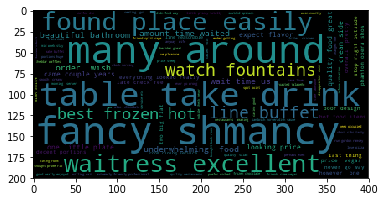

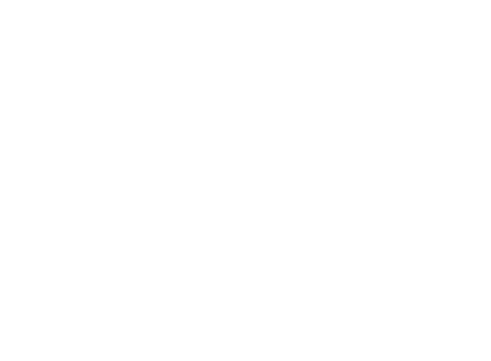

In [295]:
import matplotlib.pyplot as plt
plt.imshow(positive_cloud)
plt.figure(figsize=(8,6))
plt.axis("off")
plt.show()

In [290]:
word_negative = svm_coeffs_df_ngram[(svm_coeffs_df_ngram['ngram'].str.len() > 10) & (svm_coeffs_df_ngram['weight'] < 0.0)] \
.sort_values('weight')

In [297]:
word_negative.to_csv('word_negative.csv')

In [291]:
tuples = tuple([tuple(x) for x in word_negative['ngram'].value_counts().reset_index().values])
#print (tuples)
#(('euro 2016', 2), ('wimbledon', 1), ('match of the day', 1))

negative_cloud = WordCloud()
#https://stackoverflow.com/q/38247648/2901002
negative_cloud.generate_from_frequencies(dict(tuples))


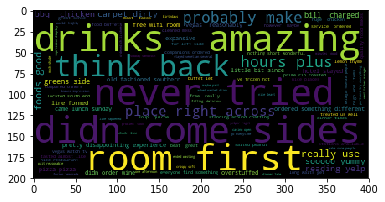

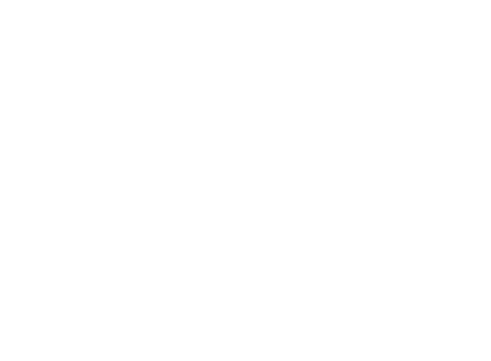

In [294]:
import matplotlib.pyplot as plt
plt.imshow(negative_cloud)
plt.figure(figsize=(8,6))
plt.axis("off")
plt.show()